In [1]:
import sys, os, time, datetime, h5py
import numpy as np

import matplotlib.pyplot as plt #pip install matplotlib
import matplotlib.font_manager as font_manager
plt.rcParams["font.family"] = "serif"
plt.style.use('classic')
font = font_manager.FontProperties(family='serif', size=16)

from scipy.stats import norm, expon, chi2, uniform, chisquare, t

## How good is your generative model?

In the previous two tutorials we have seen two examples of generative models applied to fundamental physics datasets.

However, the degree to which generative techniques can substitute traditional approaches of data simulation and analysis depends on the level of accuracy and control required to tackle specific applications.  

For the purpose of discovery new physics phenomena, for instance, generative models could be used to produce a synthetic representation of the physics as we now it today, e.g. our null hypothesis, to be compared with incoming experimental data. Poor models could lead to inaccurate representations of the theory, reducing the discovery power of the experiment or biasing the analysis toward non-physical features.

Alongside improving generative models, it is therefore crucial to develop competitive tools to test their goodness, and use them to control the extent to which generative models can be trusted.

Here some literature proposing machine-learning based solutions to data validation:

- "A Kernel Two-Sample Test" http://jmlr.org/papers/v13/gretton12a.html
- "Revisiting Classifier Two-Sample Tests" https://arxiv.org/abs/1610.06545
- "Goodness of fit by Neyman-Pearson testing" https://scipost.org/SciPostPhys.16.5.123
- "Comparison of Affine and Rational Quadratic Spline Coupling and Autoregressive Flows through Robust Statistical Tests" https://www.mdpi.com/2073-8994/16/8/942
- "Evaluating generative models in high energy physics" https://journals.aps.org/prd/abstract/10.1103/PhysRevD.107.076017
- "How to Understand Limitations of Generative Networks" https://scipost.org/submissions/2305.16774v2

In this tutorial we will explore some basic approaches to data validation based on a binary classifiers.

______________________________
## Classifier Two-Sample Tests

Let's assume we have been given two samples, $S_0$ and $S_1$, the former coming from the original distribution and the latter from the generative model targeting it.
The main idea is to train a binary classifier to tell the two samples apart. 
Different metrics can be used to quantify the distance between the two samples based on the classifier output.

Let's define some:

- *balanced accuracy*:
  $${\rm BACC}(S_1, S_0)= 0.5 \frac{N_0(c<0.5)}{N_0} + 0.5 \frac{N_1(c>0.5)}{N_1}$$

In [142]:
def balanced_accuracy(true, pred):
    y = true[:, 0]
    f = pred[:, 0]
    if torch.sum(1-y)>0 and torch.sum(y)>0:
        return 0.5*torch.sum((1-y)*(f<0.5))/torch.sum(1-y) + 0.5*torch.sum(y*(f>=0.5))/torch.sum(y)
    elif torch.sum(1-y)==0 and torch.sum(y)>0:
        return torch.sum(y*(f>=0.5))/torch.sum(y)
    elif torch.sum(1-y)>0 and torch.sum(y)==0:
        return torch.sum((1-y)*(f<0.5))/torch.sum(1-y)
    else:
        return torch.tensor([0])

- *likelihood-ratio*:
  $${\rm LRT}(S_1, S_0) = 2\left[ \sum_{x\in S_1} f(x) + \frac{N_1}{N_0}\sum_{x\in S_0}\left(1-e^{f(x)}\right)\right]$$
  where $f(x)=\log\frac{n(x|S_1)}{n(x|S_0)}$ is the log-density-ratio between the two samples density functions

In [290]:
def likelihood_ratio(true, pred, weight):
    f   = pred[:, 0]
    y   = true[:, 0]
    w = weight[:, 0]
    return 2*torch.sum((1-y)*w*(1-torch.exp(f)) + y*w*f) 

### Define a classifier
Let's also define a classifier model and loss function.

In [317]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from einops import rearrange #pip install einops
from typing import List
from torch.utils.data import DataLoader

class classifier(nn.Module):
    def __init__(self, input_dim: int=1, output_dim: int=1, layers: List=[4]):
        super(classifier, self).__init__()
        self.input_layer = nn.Linear(input_dim, layers[0])
        self.hidden_layers = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) 
                                         for i in range(len(layers)-1)])
        self.output_layer = nn.Linear(layers[-1], output_dim)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.input_layer(x))
        if len(self.hidden_layers):
            for i, layer in enumerate(self.hidden_layers):
                x = self.relu(layer(x))
        x = self.sigmoid(self.output_layer(x))
        return x

def weighted_binary_crossentropy(output, target, weight):
    y = target[:, 0]
    w = weight[:, 0]
    f = output[:, 0]
    return -1*torch.mean(y*w*torch.log(f) + (1-y)*w*torch.log(1-f))

def inv_sigmoid(p):
    return torch.log(p/(1-p)) 

### Proof-of-concept: 1D toy model
*based on the experiments in* <a href="https://scipost.org/SciPostPhys.16.5.123" target="_blank">*Goodness of fit by Neyman-Pearson testing*</a> 
*and* <a href="https://arxiv.org/abs/1610.06545" target="_blank">*Revisiting Classifier Two-Sample Tests*</a>

We consider a 1D toy model in which the original target distribution is a standard Gaussian, and the generative model approximating it is a Student-t distribution with arbitrary number of degrees of freedom $\nu$.
Note that for $\nu\rightarrow\infty$ the Student-t distribution converges to a standard Gaussian. Varying $\nu$ allows to simulate arbitrarily subtle mis-modeling of the generative model.

#### A. comparing normal and student t distributions

In [368]:
seed = 1234
print('Random seed: '+str(seed))

# define the original distribution as a standard normal
gaus_loc, gaus_scale = 0, 1
# define the generated distribution as a student t with parameter 'student_nu'
student_nu = 6

# statistics                                                                                                                                                     
N_0     = 10000 # number of data points from the original distribution
N_1     = 1000 # number of data points from the generated distribution

# generate the samples:
sample_1 = t.rvs(df=student_nu, size=(N_1,1))
sample_0 = norm.rvs(loc=gaus_loc, scale=gaus_scale, size=(N_0, 1))

# balance the classes via reweighting
relative_weight = N_1*1./N_0
weight_1  = torch.ones((N_1,1))
weight_0  = torch.ones((N_0,1))*relative_weight

Random seed: 1234


/tmp/ipykernel_183749/62858494.py:24: RuntimeWarning: divide by zero encountered in divide
  plt.errorbar(x, hD[0]/hR[0], yerr=np.sqrt(hD[0])/hR[0], ls='', marker='o', label ='generated/original', color='black')
/tmp/ipykernel_183749/62858494.py:24: RuntimeWarning: invalid value encountered in divide
  plt.errorbar(x, hD[0]/hR[0], yerr=np.sqrt(hD[0])/hR[0], ls='', marker='o', label ='generated/original', color='black')
/opt/conda/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3683: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.vstack([-(1 - lolims), 1 - uplims]) * err


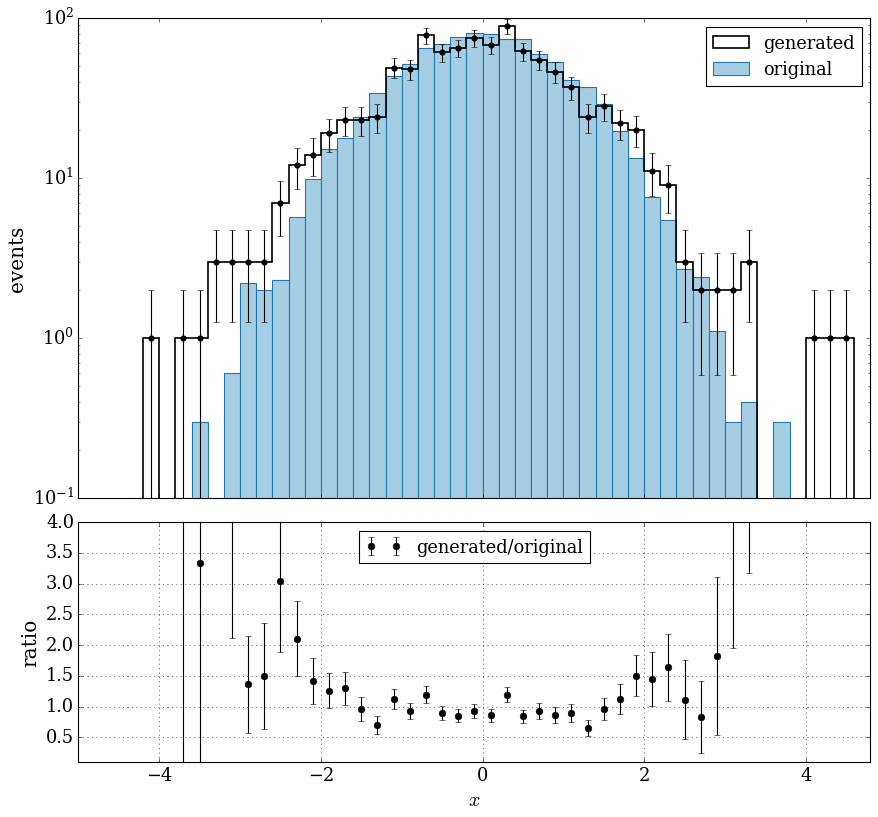

In [369]:
# plot distributions
fig = plt.figure(figsize=(10, 10))                                                                                                                                            
fig.patch.set_facecolor('white')   

bins=np.arange(-5, 5, 0.2) 

ax1 = fig.add_axes([0., 0.33, 0.99, 0.6])        
hD = plt.hist(sample_1[:, 0],weights=weight_1, 
              bins=bins, label='generated', color='black', lw=1.5, histtype='step', zorder=4)
hR = plt.hist(sample_0[:, 0], weights=weight_0, color='#a6cee3',     
              ec='#1f78b4', bins=bins, lw=1, label='original')
plt.errorbar(0.5*(bins[1:]+bins[:-1]), hD[0],  yerr= np.sqrt(hD[0]), color='black', ls='', marker='o', ms=5, zorder=3)
font = font_manager.FontProperties(family='serif', size=16)
l    = plt.legend(fontsize=18, prop=font)
font = font_manager.FontProperties(family='serif', size=18) 
plt.tick_params(axis='x', which='both',    labelbottom=False)
plt.yticks(fontsize=16, fontname='serif')
plt.xlim(bins[0], bins[-1])
plt.yscale('log')
plt.ylabel('events', fontsize=18, fontname='serif')

ax2 = fig.add_axes([0., 0., 0.99, 0.3]) 
x = 0.5*(bins[1:]+bins[:-1])
plt.errorbar(x, hD[0]/hR[0], yerr=np.sqrt(hD[0])/hR[0], ls='', marker='o', label ='generated/original', color='black')
font = font_manager.FontProperties(family='serif', size=16)
plt.legend(fontsize=18, prop=font, loc='best')
plt.xlabel(r'$x$', fontsize=18, fontname='serif')
plt.ylabel('ratio', fontsize=18, fontname='serif')
plt.ylim(0.1, 4)
plt.yticks(fontsize=16, fontname='serif')
plt.xticks(fontsize=16, fontname='serif')
plt.xlim(bins[0], bins[-1])
#plt.yscale('log')
plt.grid() 
plt.show()

##### let's run the classifier

In [370]:
# initialize model
model = classifier(layers=[20])
print(model)
model.cuda()

# initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# initilie loss
criterion = weighted_binary_crossentropy

# define data loader
data_tr = torch.concat([torch.from_numpy(sample_0), torch.from_numpy(sample_1)])
weight_tr = torch.concat([weight_0, weight_1])
target_0 = torch.zeros((N_0,1))
target_1 = torch.ones((N_1,1))
target_tr = torch.concat([target_0, target_1])
train_loader = DataLoader(list(zip(data_tr, target_tr, weight_tr)), batch_size=N_0+N_1, shuffle=True, drop_last=True, num_workers=4)

classifier(
  (input_layer): Linear(in_features=1, out_features=20, bias=True)
  (hidden_layers): ModuleList()
  (output_layer): Linear(in_features=20, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)


In [371]:
loss_history = []

In [372]:
n_epochs = 100 # you may increase this number to train a final model
for epoch in range(1, n_epochs+1):
    # keep track of training and validation loss
    train_loss = 0.0
    model.train()
    for idx, (data, target, weight) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        target, data, weight = target.float(), data.float(), weight.float()
        data, target, weight = data.cuda(), target.cuda(), weight.cuda()
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target, weight)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

    # calculate average losses
    train_loss = train_loss*1./len(train_loader.dataset)
    loss_history.append(train_loss)
    if not epoch%10:
        print('Epoch: {} \tTraining Loss: {:.6f}'  .format(epoch, train_loss))
    
    # save model if validation loss has decreased
    torch.save(model.state_dict(), './c2st-gaus-student.pt')

Epoch: 10 	Training Loss: 0.131412
Epoch: 20 	Training Loss: 0.129499
Epoch: 30 	Training Loss: 0.128198
Epoch: 40 	Training Loss: 0.127399
Epoch: 50 	Training Loss: 0.126936
Epoch: 60 	Training Loss: 0.126657
Epoch: 70 	Training Loss: 0.126462
Epoch: 80 	Training Loss: 0.126305
Epoch: 90 	Training Loss: 0.126172
Epoch: 100 	Training Loss: 0.126056


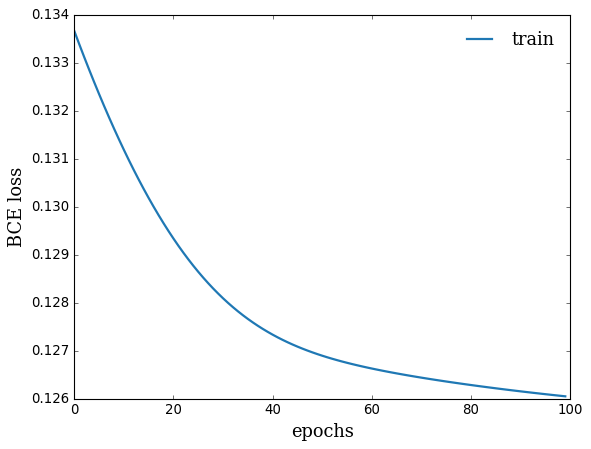

In [373]:
fig = plt.figure(figsize=(8, 6))
fig.patch.set_facecolor('white')
plt.plot(loss_history, label='train', color='#1f78b4', lw=2)
plt.ylabel('BCE loss', fontname='serif', fontsize=16)
plt.xlabel('epochs', fontname='serif', fontsize=16)
plt.legend(prop=font, loc='best', frameon=False)
#plt.yscale('log')
plt.show() 

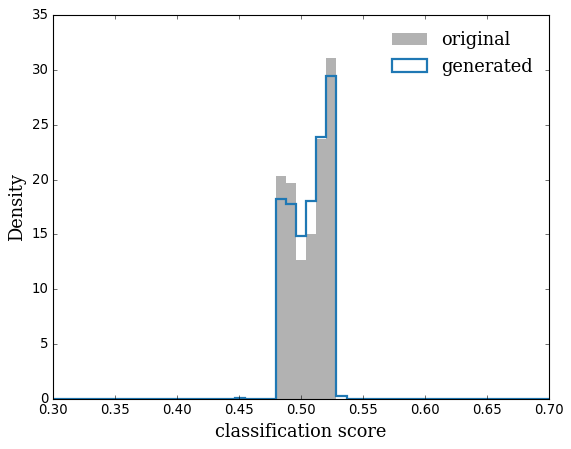

In [374]:
with torch.no_grad():
    fig = plt.figure(figsize=(8, 6))
    fig.patch.set_facecolor('white')
    output = model(data)[:, 0:1]
    bins = np.linspace(0.3,0.7,50)
    plt.hist(output[target[:, 0]==0].cpu().numpy(), bins=bins, density=True, color='black', ec='none', 
             alpha=0.3, label='original')
    plt.hist(output[target[:, 0]==1].cpu().numpy(), bins=bins, density=True, color='#1f78b4', 
             label='generated', histtype='step', lw=2)
    plt.xlabel("classification score", fontname='serif', fontsize=16)
    plt.ylabel("Density", fontname='serif', fontsize=16)
    #plt.yscale('log')
    plt.legend(prop=font, loc='best', frameon=False)
    plt.show()

In [375]:
output = model(data)
bacc_obs = balanced_accuracy(true=target, pred=output[:, 0:1]).item()#.cpu()
logr = inv_sigmoid(model(data))#torch.log(model(data)[:, 1:2]/model(data)[:, 0:1])#output[:, 1:2]
lrt_obs = likelihood_ratio(true=target, pred=logr, weight=weight).item()#.cpu()
print("BACC: ", bacc_obs)
print("LRT: ", lrt_obs)

BACC:  0.5091999769210815
LRT:  -0.9213213920593262


#### B. What would be the classification score output in *absence* of discrepancies? (normal vs normal)
Let's have a look at the output of the binary classifier trained on two samples coming from the same distribution

In [327]:
seed = 1234
np.random.seed(seed)
print('Random seed: '+str(seed))

# define the original distribution as a standard normal
gaus_loc, gaus_scale = 0, 1

# statistics                                                                                                                                                     
N_0     = 10000 # number of data points from the original distribution
N_1     = 1000 # number of data points from the generated distribution (=original)

# generate the samples:
sample_1 = norm.rvs(loc=gaus_loc, scale=gaus_scale, size=(N_1, 1)) # (=original)
sample_0 = norm.rvs(loc=gaus_loc, scale=gaus_scale, size=(N_0, 1))

# balance the classes via reweighting
relative_weight = N_1*1./N_0
weight_1  = torch.ones((N_1,1))
weight_0  = torch.ones((N_0,1))*relative_weight


Random seed: 1234


/tmp/ipykernel_183749/62858494.py:24: RuntimeWarning: invalid value encountered in divide
  plt.errorbar(x, hD[0]/hR[0], yerr=np.sqrt(hD[0])/hR[0], ls='', marker='o', label ='generated/original', color='black')


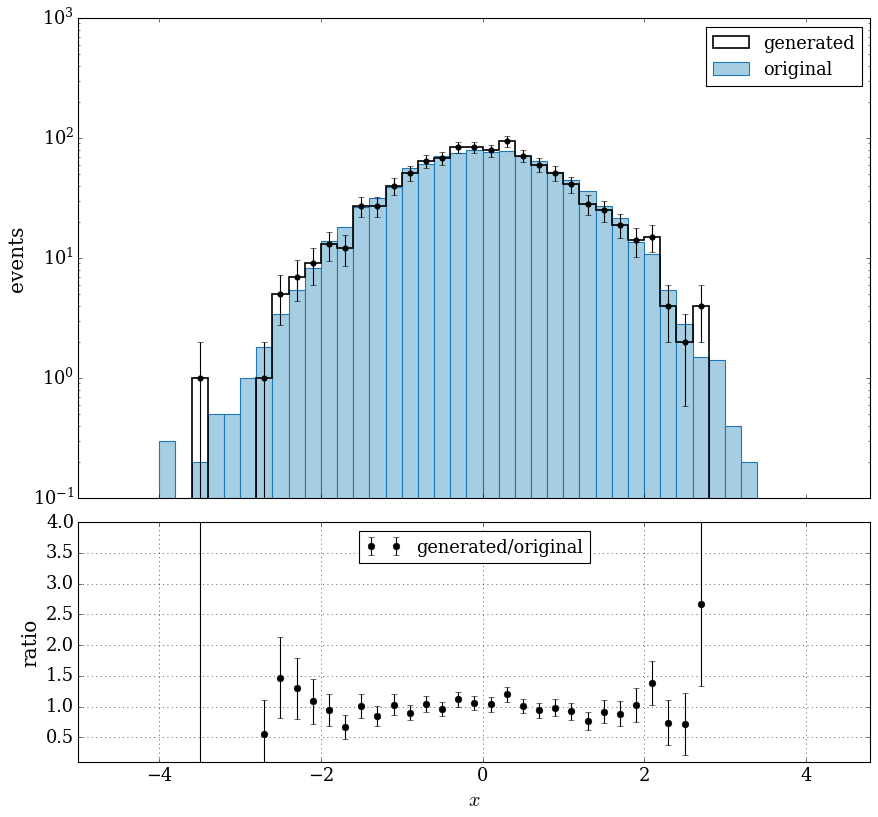

In [328]:
# plot distributions
fig = plt.figure(figsize=(10, 10))                                                                                                                                            
fig.patch.set_facecolor('white')   

bins=np.arange(-5, 5, 0.2) 

ax1 = fig.add_axes([0., 0.33, 0.99, 0.6])        
hD = plt.hist(sample_1[:, 0],weights=weight_1, 
              bins=bins, label='generated', color='black', lw=1.5, histtype='step', zorder=4)
hR = plt.hist(sample_0[:, 0], weights=weight_0, color='#a6cee3',     
              ec='#1f78b4', bins=bins, lw=1, label='original')
plt.errorbar(0.5*(bins[1:]+bins[:-1]), hD[0],  yerr= np.sqrt(hD[0]), color='black', ls='', marker='o', ms=5, zorder=3)
font = font_manager.FontProperties(family='serif', size=16)
l    = plt.legend(fontsize=18, prop=font)
font = font_manager.FontProperties(family='serif', size=18) 
plt.tick_params(axis='x', which='both',    labelbottom=False)
plt.yticks(fontsize=16, fontname='serif')
plt.xlim(bins[0], bins[-1])
plt.yscale('log')
plt.ylabel('events', fontsize=18, fontname='serif')

ax2 = fig.add_axes([0., 0., 0.99, 0.3]) 
x = 0.5*(bins[1:]+bins[:-1])
plt.errorbar(x, hD[0]/hR[0], yerr=np.sqrt(hD[0])/hR[0], ls='', marker='o', label ='generated/original', color='black')
font = font_manager.FontProperties(family='serif', size=16)
plt.legend(fontsize=18, prop=font, loc='best')
plt.xlabel(r'$x$', fontsize=18, fontname='serif')
plt.ylabel('ratio', fontsize=18, fontname='serif')
plt.ylim(0.1, 4)
plt.yticks(fontsize=16, fontname='serif')
plt.xticks(fontsize=16, fontname='serif')
plt.xlim(bins[0], bins[-1])
#plt.yscale('log')
plt.grid() 
plt.show()

##### let's run the classifier

In [329]:
# initialize model
model = classifier(layers=[20])
print(model)
model.cuda()

# initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# initilie loss
criterion = weighted_binary_crossentropy

# define data loader
data_tr = torch.concat([torch.from_numpy(sample_0), torch.from_numpy(sample_1)])
weight_tr = torch.concat([weight_0, weight_1])
target_0 = torch.zeros((N_0,1))
target_1 = torch.ones((N_1,1))
target_tr = torch.concat([target_0, target_1])
train_loader = DataLoader(list(zip(data_tr, target_tr, weight_tr)), batch_size=N_0+N_1, shuffle=True, drop_last=True, num_workers=4)

classifier(
  (input_layer): Linear(in_features=1, out_features=20, bias=True)
  (hidden_layers): ModuleList()
  (output_layer): Linear(in_features=20, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)


In [330]:
loss_history = []

In [331]:
n_epochs = 100 # you may increase this number to train a final model
for epoch in range(1, n_epochs+1):
    # keep track of training and validation loss
    train_loss = 0.0
    model.train()
    for idx, (data, target, weight) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        target, data, weight = target.float(), data.float(), weight.float()
        data, target, weight = data.cuda(), target.cuda(), weight.cuda()
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target, weight)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

    # calculate average losses
    train_loss = train_loss*1./len(train_loader.dataset)
    loss_history.append(train_loss)
    if not epoch%10:
        print('Epoch: {} \tTraining Loss: {:.6f}'  .format(epoch, train_loss))
    
    # save model if validation loss has decreased
    torch.save(model.state_dict(), './c2st-gaus-student.pt')

Epoch: 10 	Training Loss: 0.131148
Epoch: 20 	Training Loss: 0.129171
Epoch: 30 	Training Loss: 0.127798
Epoch: 40 	Training Loss: 0.126931
Epoch: 50 	Training Loss: 0.126435
Epoch: 60 	Training Loss: 0.126181
Epoch: 70 	Training Loss: 0.126064
Epoch: 80 	Training Loss: 0.126016
Epoch: 90 	Training Loss: 0.125998
Epoch: 100 	Training Loss: 0.125990


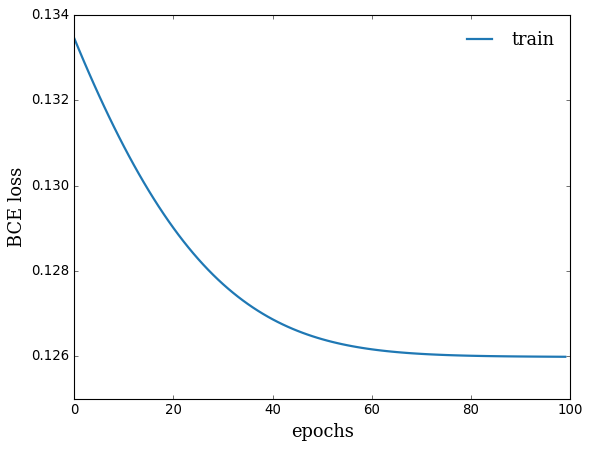

In [332]:
fig = plt.figure(figsize=(8, 6))
fig.patch.set_facecolor('white')
plt.plot(loss_history, label='train', color='#1f78b4', lw=2)#'#EA4F88')
plt.ylabel('BCE loss', fontname='serif', fontsize=16)
plt.xlabel('epochs', fontname='serif', fontsize=16)
plt.legend(prop=font, loc='best', frameon=False)
#plt.yscale('log')
plt.show() 

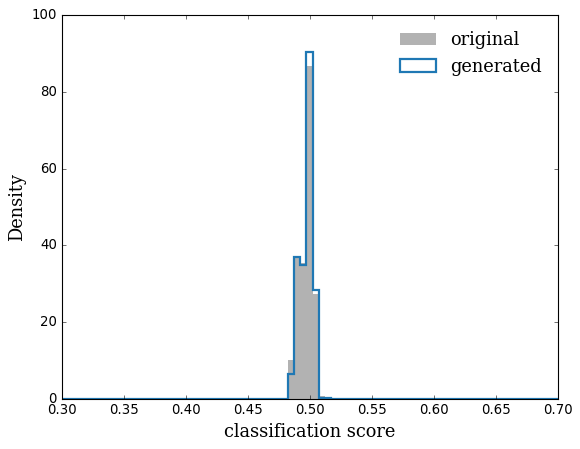

In [333]:
with torch.no_grad():
    fig = plt.figure(figsize=(8, 6))
    fig.patch.set_facecolor('white')
    output = model(data)[:, 0:1]
    bins = np.linspace(0.3,0.7,80)
    plt.hist(output[target[:, 0]==0].cpu().numpy(), bins=bins, density=True, color='black', ec='none', 
             alpha=0.3, label='original')
    plt.hist(output[target[:, 0]==1].cpu().numpy(), bins=bins, density=True, color='#1f78b4', 
             label='generated', histtype='step', lw=2)
    plt.xlabel("classification score", fontname='serif', fontsize=16)
    plt.ylabel("Density", fontname='serif', fontsize=16)
    #plt.yscale('log')
    plt.legend(prop=font, loc='best', frameon=False)
    plt.show()

In [334]:
output = model(data)
bacc = balanced_accuracy(true=target, pred=output[:, 0:1]).item()#.cpu()
logr = inv_sigmoid(model(data))#torch.log(model(data)[:, 1:2]/model(data)[:, 0:1])#output[:, 1:2]
lrt = likelihood_ratio(true=target, pred=logr, weight=weight).item()#.cpu()
print("BACC: ", bacc)
print("LRT: ", lrt)

BACC:  0.5128999948501587
LRT:  1.6446688175201416


## Calibration

metrics need to be calibrated in order to assess the significance of the result. This means comparing the observed value of the metric with its *null distribution* obtained by simulating experiments in absence of discrepancy.

Let's do that for the 1D problem at hand:

### Generate toys

In [381]:
def generate_null_toy(seed, N_0, N_1):
    np.random.seed(seed)
    
    # generate the samples
    sample_1 = norm.rvs(loc=gaus_loc, scale=gaus_scale, size=(N_1, 1)) # (=original)
    sample_0 = norm.rvs(loc=gaus_loc, scale=gaus_scale, size=(N_0, 1))
    
    # balance the classes via reweighting
    relative_weight = N_1*1./N_0
    weight_1  = torch.ones((N_1,1))
    weight_0  = torch.ones((N_0,1))*relative_weight

    # define data loader
    data_tr = torch.concat([torch.from_numpy(sample_0), torch.from_numpy(sample_1)])
    weight_tr = torch.concat([weight_0, weight_1])
    target_0 = torch.zeros((N_0,1))
    target_1 = torch.ones((N_1,1))
    target_tr = torch.concat([target_0, target_1])
    train_loader = DataLoader(list(zip(data_tr, target_tr, weight_tr)), batch_size=N_0+N_1, shuffle=True, drop_last=True, num_workers=4)
    return train_loader

def generate_alternative_toy(seed, student_nu, N_0, N_1):
    np.random.seed(seed)
    
    # generate the samples
    sample_1 = t.rvs(df=student_nu, size=(N_1,1))
    sample_0 = norm.rvs(loc=gaus_loc, scale=gaus_scale, size=(N_0, 1))
    
    # balance the classes via reweighting
    relative_weight = N_1*1./N_0
    weight_1  = torch.ones((N_1,1))
    weight_0  = torch.ones((N_0,1))*relative_weight

    # define data loader
    data_tr = torch.concat([torch.from_numpy(sample_0), torch.from_numpy(sample_1)])
    weight_tr = torch.concat([weight_0, weight_1])
    target_0 = torch.zeros((N_0,1))
    target_1 = torch.ones((N_1,1))
    target_tr = torch.concat([target_0, target_1])
    train_loader = DataLoader(list(zip(data_tr, target_tr, weight_tr)), batch_size=N_0+N_1, shuffle=True, drop_last=True, num_workers=4)
    return train_loader

### null distribution from toys

In [ ]:
LRT_null = np.array([])
BACC_null = np.array([])

In [360]:
N_toys = 10 # you may increase this number to increase the accuracy of the calibration
n_epochs = 100 # you may increase this number to train a final model

for toy in range(N_toys):
    # initialie data loader
    seed = toy+1234
    train_loader = generate_null_toy(seed, N_0, N_1)
    
    # initialize model
    model = classifier(layers=[20])
    model.cuda()
    
    # initialize optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # initialie loss
    criterion = weighted_binary_crossentropy
    
    #train
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0
        model.train()
        for idx, (data, target, weight) in enumerate(train_loader):
            target, data, weight = target.float(), data.float(), weight.float()
            data, target, weight = data.cuda(), target.cuda(), weight.cuda()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target, weight)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
            
    # calculate average losses
    train_loss = train_loss*1./len(train_loader.dataset)
    
    # calculate metrics
    output = model(data)
    bacc = balanced_accuracy(true=target, pred=output[:, 0:1]).item()
    lrt = likelihood_ratio(true=target, pred=inv_sigmoid(output), weight=weight).item()
    BACC_null=np.append(BACC_null, bacc)
    LRT_null=np.append(LRT_null, lrt)
    print('Toy %i, Final Loss: %f, BACC: %f, LRT: %f'  %(toy, train_loss, bacc, lrt))
    

Toy 0, Final Loss: 0.126226, BACC: 0.492150, LRT: -8.793271
Toy 1, Final Loss: 0.126152, BACC: 0.498550, LRT: -5.319113
Toy 2, Final Loss: 0.126038, BACC: 0.498950, LRT: -0.453333
Toy 3, Final Loss: 0.126262, BACC: 0.495550, LRT: -10.909985
Toy 4, Final Loss: 0.126033, BACC: 0.502650, LRT: -0.233412
Toy 5, Final Loss: 0.126044, BACC: 0.501450, LRT: -0.729044
Toy 6, Final Loss: 0.126396, BACC: 0.498450, LRT: -16.559387
Toy 7, Final Loss: 0.125964, BACC: 0.509050, LRT: 2.819908
Toy 8, Final Loss: 0.126255, BACC: 0.494700, LRT: -9.464224
Toy 9, Final Loss: 0.125956, BACC: 0.513050, LRT: 3.138071


In [382]:
LRT_alt = np.array([])
BACC_alt = np.array([])

In [383]:
N_toys = 10 # you may increase this number to increase the accuracy of the calibration
n_epochs = 100 # you may increase this number to train a final model
student_nu = 6

for toy in range(N_toys):
    # initialie data loader
    seed = toy+1234
    train_loader = generate_alternative_toy(seed, student_nu, N_0, N_1)
    
    # initialize model
    model = classifier(layers=[20])
    model.cuda()
    
    # initialize optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # initialie loss
    criterion = weighted_binary_crossentropy
    
    #train
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0
        model.train()
        for idx, (data, target, weight) in enumerate(train_loader):
            target, data, weight = target.float(), data.float(), weight.float()
            data, target, weight = data.cuda(), target.cuda(), weight.cuda()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target, weight)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
            
    # calculate average losses
    train_loss = train_loss*1./len(train_loader.dataset)
    
    # calculate metrics
    output = model(data)
    bacc = balanced_accuracy(true=target, pred=output[:, 0:1]).item()
    lrt = likelihood_ratio(true=target, pred=inv_sigmoid(output), weight=weight).item()
    BACC_alt=np.append(BACC_alt, bacc)
    LRT_alt=np.append(LRT_alt, lrt)
    print('Toy %i, Final Loss: %f, BACC: %f, LRT: %f'  %(toy, train_loss, bacc, lrt))
    

Toy 0, Final Loss: 0.125559, BACC: 0.512850, LRT: 26.045433
Toy 1, Final Loss: 0.125532, BACC: 0.505900, LRT: 25.417850
Toy 2, Final Loss: 0.125607, BACC: 0.498850, LRT: 23.827747
Toy 3, Final Loss: 0.126006, BACC: 0.500200, LRT: 1.352667
Toy 4, Final Loss: 0.125584, BACC: 0.513450, LRT: 22.551128
Toy 5, Final Loss: 0.125044, BACC: 0.526650, LRT: 50.605076
Toy 6, Final Loss: 0.124699, BACC: 0.535650, LRT: 70.271416
Toy 7, Final Loss: 0.125108, BACC: 0.526450, LRT: 49.005199
Toy 8, Final Loss: 0.125116, BACC: 0.526000, LRT: 47.703545
Toy 9, Final Loss: 0.126232, BACC: 0.509200, LRT: 0.521252


### Calibration (aka type I error)

Be $t_0$ the random variable describing the two-sample test in absence of discrepancies (null hypothesis), and be $t_1$ the random variable describing the outcome of the test on the actual generated sample
We can define a threshold value $q_{\alpha}$ such that the rate of $t_0$ exceeding the threshold is $\alpha$: $\int^{+\infty}_{q_{\alpha}}t_0\, dt_0=\alpha$.\
Given a threshold $q_{\alpha}$, we cna define the errors on $t_1$ as follows:
- *type I error*:
  $e_1=\int^{+\infty}_{q_{\alpha}}t_1\, dt_1$
  
- *type II error*:
  $e_2=\int_{-\infty}^{q_{\alpha}}t_1\, dt_1$
  


In [365]:
def type_I_error(test0, test1, alpha=0.05):
    q_alpha = np.quantile(test0, 1-alpha)
    return np.sum(test1>q_alpha)/float(len(test1))

def type_II_error(test0, test1,  alpha=0.05):
    q_alpha = np.quantile(test0, 1-alpha)
    return np.sum(test1<q_alpha)/float(len(test1))

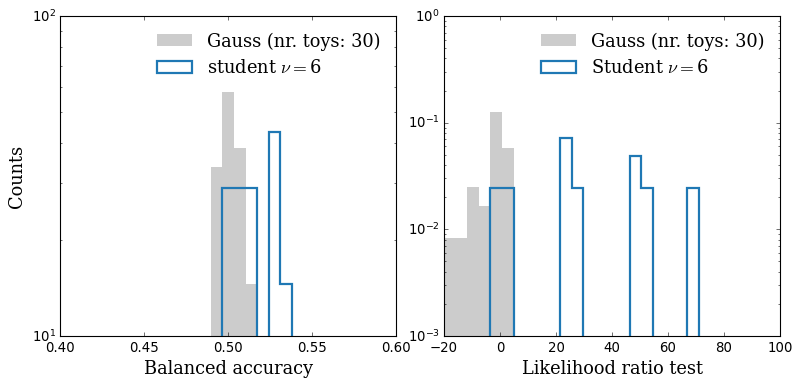

In [384]:
fig = plt.figure(figsize=(12, 5))
fig.patch.set_facecolor('white')


# plot BACC calibration
ax = fig.add_axes([0.05, 0.1, 0.35, 0.8])
bins=np.linspace(0.4, 0.6, 30)
h=plt.hist(BACC_null, alpha=0.2, bins=bins, density=True, label='Gauss (nr. toys: %i)'%(len(BACC_null)),color='black', ec='none')
plt.hist(BACC_alt, histtype='step', lw=2, bins=h[1], density=True, label=r'student $\nu=$%s'%(str(student_nu)), color='#1f78b4')
plt.xlabel('Balanced accuracy', fontname='serif', fontsize=16)
plt.ylabel('Counts', fontname='serif', fontsize=16)
plt.yscale('log')
plt.legend(prop=font, loc='upper right', frameon=False)

# plot LRT calibration
ax = fig.add_axes([0.45, 0.1, 0.35, 0.8])
bins=np.linspace(-20, 100, 30)
h=plt.hist(LRT_null, alpha=0.2, bins=bins, density=True, label='Gauss (nr. toys: %i)'%(len(LRT_null)),color='black', ec='none')
plt.hist(LRT_alt, histtype='step', lw=2, bins=h[1], density=True, label=r'Student $\nu=$%s'%(str(student_nu)), color='#1f78b4')
plt.xlabel('Likelihood ratio test', fontname='serif', fontsize=16)
plt.legend(prop=font, loc='upper right', frameon=False)
plt.yscale('log')
plt.show()

In [395]:
alpha =0.05
power_BACC = type_I_error(test0=BACC_null, test1=BACC_alt, alpha=alpha)
power_LRT = type_I_error(test0=LRT_null, test1=LRT_alt, alpha=alpha)
print("The probability of observing an outcome of the BACC test as extreme or more than the %s perc of the non-anomalous samples is %s."%(str(alpha*100), str(power_BACC)))
print("The probability of observing an outcome of the LRT test as extreme or more than the %s perc of the non-anomalous samples is %s."%(str(alpha*100), str(power_LRT)))

the probability of observing an outcome of the BACC test as extreme or more than the 5.0 perc of the non-anomalous samples is 0.6.
the probability of observing an outcome of the LRT test as extreme or more than the 5.0 perc of the non-anomalous samples is 0.8.


# Some interesting considerations and questions:
- There exist many tests that do not require machine learning. However, their scaling to large size and highly dimensional problems could not be possible. One solution is to use machine learning for dimensionality reduction prior to computing the test. How can one ensure that the discrepnacies are not lost in the process of dimensionality reduction?
- Different tests have different powers and are sensitive to different features in the data. How would you choose the right test for your application?
- The power of a test depends on the size of the tested samples. How many data points can one generate before being sensitive to mis-modeling?
- What is the impact of the classifier model design on the test outcome? Regularization schemes can help controlling the behavior of the calibration sample.
- In this notebook we showed how to build a null distribution for the two-sample test generating fresh toy data. In data scarcity conditions *permutation* techniques can be used. See for instance *Model-Independent Detection of New Physics Signals Using Interpretable Semi-Supervised Classifier Tests* (https://arxiv.org/abs/2102.07679)

# Your turn:
Can you apply any of the methods listed in the references or showed in this tutorial to the generative models you trained in the previous two tutorials?